In [1]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt

# Input your image
I'm using an online example. You should import the different test cases provided.

In [2]:
img = cv2.imread('C:/Users/Mazen Mohamed/PycharmProjects/cvphase1/16-SomethingWentTerriblyWrongHere.jpg')

if img is not None:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

else:
    print("unable to read")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

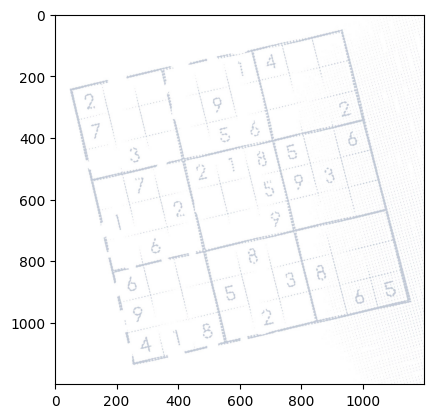

In [3]:
plt.imshow(img_rgb);

# Convert to grayscale
We don't need any color information.

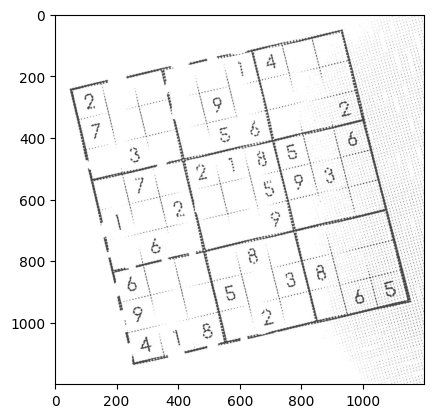

In [4]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap="gray");

# Thresholding step
We don't need the full scale of grayscale either, just binary. But, is ordinary thresholding enough? Or is "adaptive thresholding" better?

Do your research!

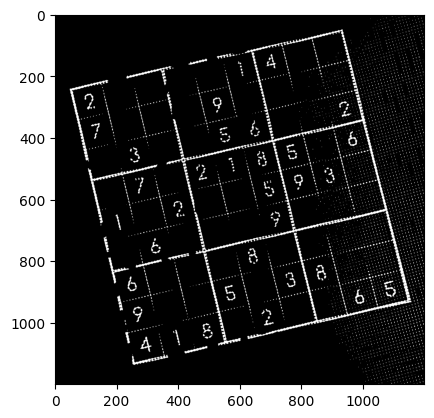

In [11]:
img_gray_threshed = cv2.adaptiveThreshold(src=img_gray,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=97,
    C=19
)
plt.imshow(img_gray_threshed, cmap="gray");

# Detect the lines
One way is to use Hough transform. It may not be the best way, there are other ways, and I've done zero noise removal in this guide so far.

This is very sub-optimal and will most likely not work reliably on all cases. Do your research!

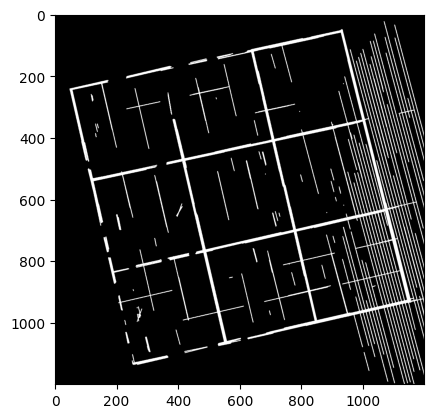

In [25]:
# Detect lines that are not smaller in length than:
minLineLength = min(img_gray_threshed.shape[0],img_gray_threshed.shape[1])/1000

lines = cv2.HoughLinesP(
    image=img_gray_threshed,
    rho=1,
    theta=np.pi/180,
    threshold=100,
    minLineLength=minLineLength,
    maxLineGap=15
)

tmp_img = np.zeros_like(img_gray_threshed, dtype = np.uint8)
for x1, y1, x2, y2 in lines[:,0]: cv2.line(tmp_img,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(tmp_img, cmap='gray');

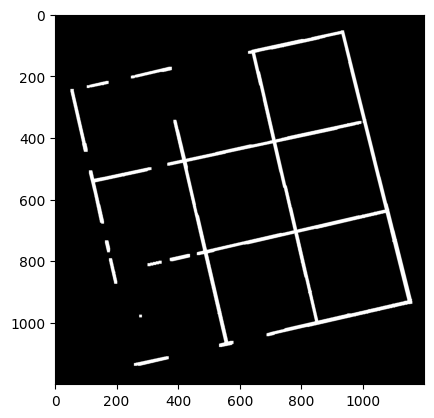

In [43]:
kernel1 =np.ones((2,2),np.uint8)
kernel=np.ones((3,3),np.uint8)
# dilation=cv2.dilate(tmp_img,kernel1,iterations=5)
erosion=cv2.erode(tmp_img,kernel1,iterations=6)
dilation=cv2.dilate(erosion,kernel,iterations=4)

# closing =cv2.morphologyEx(img_gray_threshed,cv2.MORPH_CLOSE,kernel1,iterations=1)
# opeining =cv2.morphologyEx(dilation,cv2.MORPH_OPEN,kernel1,iterations=1)
# erosion=cv2.erode(opeining,kernel1,iterations=2)
plt.imshow(dilation,cmap="gray")

# Find the intersections between the lines
Lots of magic numbers here. How to tweak? How to generalize? Do your research!

In [28]:
tmp_img2 = np.zeros_like(img_gray_threshed, dtype = np.uint16)

def angle_between_lines(line1, line2):
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    a1 = np.rad2deg(np.arctan2(l1y2 - l1y1, l1x2 - l1x1))
    a2 = np.rad2deg(np.arctan2(l2y2 - l2y1, l2x2 - l2x1))
    return np.abs(a1 - a2)

def intersection_point(line1, line2):
    # https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    nx = (l1x1*l1y2-l1y1*l1x2)*(l2x1-l2x2)-(l2x1*l2y2-l2y1*l2x2)*(l1x1-l1x2)
    ny = (l1x1*l1y2-l1y1*l1x2)*(l2y1-l2y2)-(l2x1*l2y2-l2y1*l2x2)*(l1y1-l1y2)
    d = (l1x1-l1x2)*(l2y1-l2y2)-(l1y1-l1y2)*(l2x1-l2x2)
    px = int(nx / d)
    py = int(ny / d)
    return (px, py)

def point_on_line(point, line):
    def distance(pfrom, pto): return np.sqrt((pfrom[0] - pto[0])**2 + (pfrom[1] - pto[1])**2)
    diff = distance(point, line[0:2]) + distance(point, line[2:4]) - distance(line[0:2], line[2:4])
    return np.abs(diff) < 75

intersections = []
num_of_lines = len(lines[:,0])
for i in range(num_of_lines):
    for j in range(i+1, num_of_lines):
        line1 = lines[i,0]
        line2 = lines[j,0]
        if (line1 is line2): continue
        a = angle_between_lines(line1, line2)
        if (a < 80 or a > 100): continue
        p = intersection_point(line1, line2)
        if point_on_line(p, line1) and point_on_line(p, line2):
            tmp_img2[p[::-1]] = 1201
            intersections.append(p[::-1])

plt.imshow(tmp_img2 + tmp_img, cmap="gray", vmin=0, vmax=1255);

IndexError: index 1201 is out of bounds for axis 1 with size 1200

# Take the outermost intersection points
But who said the outermost intersection points will always form the sudoku frame?

Can't use this method reliably! Do your research!

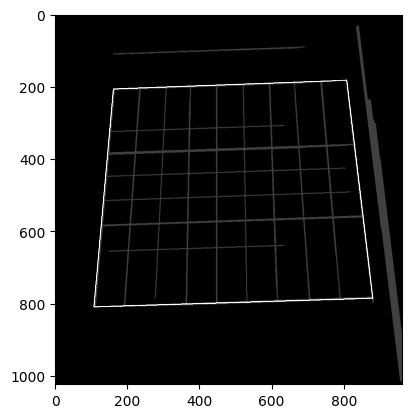

In [ ]:
p1 = sorted(intersections, key = lambda p: p[0] + p[1])[0] # topleft
p2 = sorted(intersections, key = lambda p: p[0] - p[1])[0] # topright
p3 = sorted(intersections, key = lambda p: p[0] + p[1])[-1] # bottright
p4 = sorted(intersections, key = lambda p: p[1] - p[0])[0] # bottleft
coords = np.int32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
tmp_img3 = np.zeros_like(img_gray_threshed, dtype = np.int32)
tmp_img3 = cv2.polylines(tmp_img3, coords, isClosed=True, color=(2550,0,0))
plt.imshow(tmp_img3 + tmp_img, cmap="gray", vmax=1000);

# Perform a perspective transform
Thankfully, if you got the frame right, this step is straight-forward. No research to be done here. (=

Just try not to go insane over the amount of inconsistency in coordinates between Numpy and OpenCV.

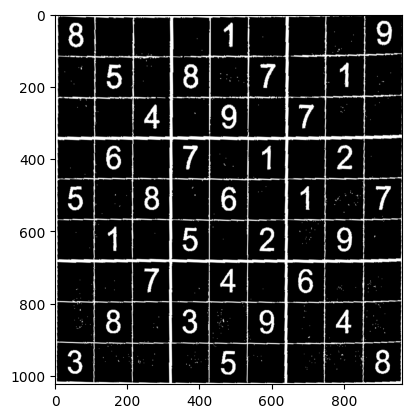

In [ ]:
y, x = img_gray_threshed.shape
src_coords = np.float32([[0,0], [x,0], [x,y], [0,y]])
dst_coords = np.float32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
img_gray_threshed_warped = cv2.warpPerspective(
    src=img_gray_threshed,
    M=cv2.getPerspectiveTransform(dst_coords, src_coords),
    dsize=img_gray_threshed.shape[::-1]
)
plt.imshow(img_gray_threshed_warped, cmap="gray");

# Separate the number tiles
Finally, you get each value in a tile of its own, ready to go to phase 2 (OCR).

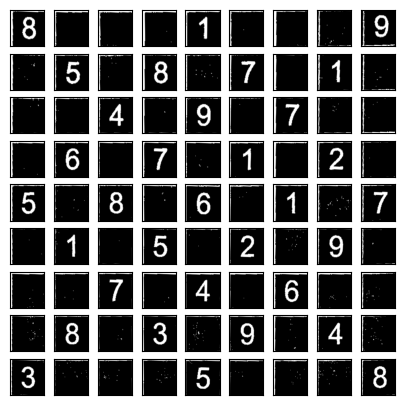

In [ ]:
M = img_gray_threshed_warped.shape[0] // 9
N = img_gray_threshed_warped.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = img_gray_threshed_warped[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(number_tiles[i][j], cmap="gray");
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)

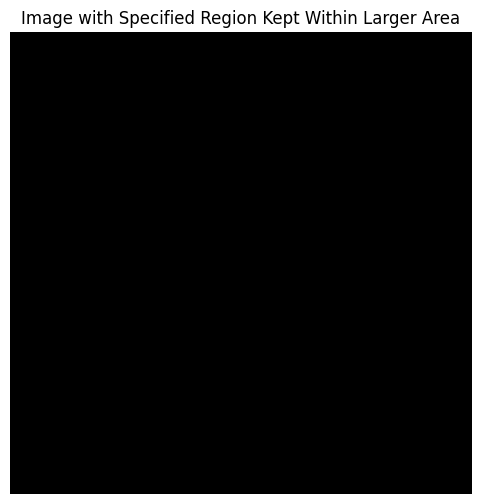

In [26]:
import cv2
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('05-Ya3amSheel2elCoinYa3am.jpg')

# Coordinates of the area to hide
top_left = (730, 0)
bottom_right = (996, 98)

# Ensure coordinates are within image bounds
if (top_left[0] < bottom_right[0]) and (top_left[1] < bottom_right[1]) \
        and (bottom_right[0] <= image.shape[1]) and (bottom_right[1] <= image.shape[0]):

    # Extract the region to hide
    region_to_hide = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    # Blur the extracted region (you can use different blurring techniques)
    blurred_region = cv2.GaussianBlur(region_to_hide, (35, 35), 0)

    # Replace the region with the blurred content
    image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = blurred_region

    # Display the image with the hidden area using plt.imshow()
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Hidden Area')
    plt.axis('off')
    plt.show()

else:
    print("Coordinates are invalid or outside image bounds")

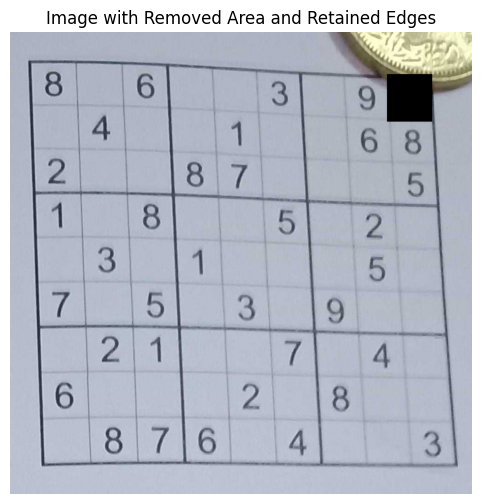

In [45]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Read the image
image = cv2.imread('05-Ya3amSheel2elCoinYa3am.jpg')

# Coordinates of the area to hide
top_left = (816, 91)
bottom_right = (914, 194)

# Ensure coordinates are within image bounds
if (top_left[0] < bottom_right[0]) and (top_left[1] < bottom_right[1]) \
        and (bottom_right[0] <= image.shape[1]) and (bottom_right[1] <= image.shape[0]):

    # Create a mask to exclude the specified region
    mask = np.zeros_like(image)
    mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = 255

    # Invert the mask
    mask_inv = cv2.bitwise_not(mask)

    # Apply bitwise AND operation to the original image and the inverted mask
    result = cv2.bitwise_and(image, mask_inv)

    # Apply bitwise AND operation with the original image to retain the edges
    final_result = cv2.bitwise_and(image, result)

    # Display the final image
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
    plt.title('Image with Removed Area and Retained Edges')
    plt.axis('off')
    plt.show()

else:
    print("Coordinates are invalid or outside image bounds")

In [48]:
import cv2

# Read the image
image = cv2.imread('05-Ya3amSheel2elCoinYa3am.jpg')

# Initialize variables for storing selected coordinates
top_left = None
bottom_right = None
cropping = False

def select_roi(event, x, y, flags, param):
    global top_left, bottom_right, cropping

    if event == cv2.EVENT_LBUTTONDOWN:
        top_left = (x, y)
        cropping = True

    elif event == cv2.EVENT_LBUTTONUP:
        bottom_right = (x, y)
        cropping = False

        # Draw the selected region on the image
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
        cv2.imshow('Select Region', image)

# Display the image and set mouse callback
cv2.imshow('Select Region', image)
cv2.setMouseCallback('Select Region', select_roi)

# Wait for the user to select the region and press 'q' to exit
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

# Display the selected coordinates
print("Top Left Coordinates:", top_left)
print("Bottom Right Coordinates:", bottom_right)

Top Left Coordinates: (608, 4)
Bottom Right Coordinates: (916, 92)


In [3]:
import cv2

# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=15000)
# Capture video from the default camera (usually webcam)
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(frame, None)

    # Draw keypoints on the frame
    frame_with_keypoints = cv2.drawKeypoints(frame, keypoints, None, color=(0, 255, 0), flags=0)

    # Display the frame with keypoints
    cv2.imshow('ORB Keypoints', frame_with_keypoints)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close windows
cap.release()
cv2.destroyAllWindows()